<AxesSubplot:xlabel='Date'>

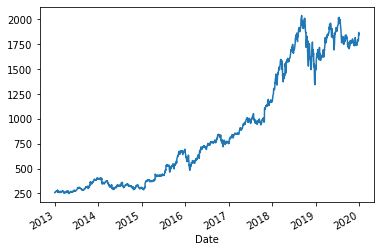

In [722]:
import pandas as pd
import yfinance as yf
import numpy as np
from yahoofinancials import YahooFinancials
AMZN = yf.download('AMZN', 
                      start='2013-01-01', 
                      end='2019-12-31', 
                      progress=False)
# AMZN = yf.download('AMZN') for all 
all_data = AMZN[['Adj Close','Open', 'High', 'Low', 'Close', 'Volume']].round(2)
all_data.head(10)
all_data['Adj Close'].plot()
# There are 1,510 and 251 observations in the training and test data respectively.

-22

In [895]:

def ts_train_test_normalize(all_data,time_steps,for_periods, n_features):
    '''
    input: 
      data: dataframe with dates and price data
    output:
      X_train, y_train: data from 2013/1/1-2018/12/31
      X_test:  data from 2019 -
      sc:      insantiated MinMaxScaler object fit to the training data
    '''
    # create training and test set

    #n_features = 1
            
    # scale the data
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.preprocessing import StandardScaler
    from sklearn.preprocessing import RobustScaler
    from sklearn.preprocessing import Normalizer
    from sklearn.preprocessing import QuantileTransformer
    #sc = MinMaxScaler()
    #sc = RobustScaler()
    #sc = Normalizer()
    sc = QuantileTransformer(output_distribution='normal')
    #sc = StandardScaler()
    
    #transform each range to scale
    
    sc.fit(all_data[(all_data.index<'2019')].iloc[:,0:n_features])
    
    #transform each range to scale
    
    #s_train_scaled = all_data[(all_data.index<'2017')].iloc[:,0:n_features].values
    ts_train_scaled = sc.transform(all_data[(all_data.index<='2017')].iloc[:,0:n_features])    
    #ts_valid_scaled = all_data[(all_data.index>='2017')&(all_data.index<'2019')].iloc[:,0:n_features].values
    ts_valid_scaled = sc.transform(all_data[(all_data.index>'2017')&(all_data.index<'2019')].iloc[:,0:n_features])
    #ts_test_scaled  = all_data[(all_data.index>='2019')].iloc[:,0:n_features].values
    ts_test_scaled  = sc.transform(all_data[(all_data.index>='2019')].iloc[:,0:n_features])
    
    #new_series = pd.DataFrame(all_data[:'2017'].iloc[:,0:n_features].values).append(pd.DataFrame(all_data['2017':'2018'].iloc[:,0:n_features].values),ignore_index=True).append(pd.DataFrame(all_data['2019':].iloc[:,0:n_features].values),ignore_index=True)
    new_series = pd.DataFrame(ts_train_scaled).append(pd.DataFrame(ts_valid_scaled)).append(pd.DataFrame(ts_test_scaled))
    
    series_reshaped = np.array([new_series[i:i + (n_steps+n_ahead)].copy() for i in range(len(all_data) - (n_steps+n_ahead))])        
    
    X_train = series_reshaped[:len(ts_train_scaled)-(n_steps+n_ahead)+2,:n_steps]
    X_valid = series_reshaped[len(ts_train_scaled)-(n_steps+n_ahead)+2:len(ts_train_scaled)-(n_steps+n_ahead)+2+len(ts_valid_scaled),:n_steps]
    X_test = series_reshaped[-len(ts_test_scaled)+2:,:n_steps]
    
    Y = np.empty(((len(all_data) - n_steps - n_ahead), n_steps, n_ahead))  
    
    for step_ahead in range(1, n_ahead + 1):     
       Y[..., step_ahead - 1] =   series_reshaped[..., step_ahead:step_ahead + n_steps, 0]

    Y_train = Y[:len(ts_train_scaled)-(n_steps+n_ahead)+2,:n_steps]
    Y_valid = Y[len(ts_train_scaled)-(n_steps+n_ahead)+2:len(ts_train_scaled)-(n_steps+n_ahead)+2+len(ts_valid_scaled),:n_steps]
    Y_test = Y[-len(ts_test_scaled)+2:,:n_steps]
    
    #print(ts_train_scaled)
    return X_train, Y_train, X_valid, Y_valid, X_test, sc


In [896]:
n_steps = 21
n_ahead = 1
n_features = len(all_data)

X_train, Y_train, X_valid, Y_valid, X_test, sc = ts_train_test_normalize(all_data,n_steps,n_ahead,n_features)
print(X_train.shape[0],X_train.shape[1],X_train.shape[2])
print(Y_train.shape[0],Y_train.shape[1],Y_train.shape[2])
print(X_valid.shape[0],X_valid.shape[1],X_valid.shape[2])
print(Y_valid.shape[0],Y_valid.shape[1],Y_valid.shape[2])
print(X_test.shape[0],X_test.shape[1],X_test.shape[2])

988 21 6
988 21 1
502 21 6
502 21 1
249 21 6


In [897]:
import tensorflow as tf
from tensorflow import keras
epochs_ = 100
batch_size_ = 150

np.random.seed(42)
tf.random.set_seed(42)

from keras.layers import Dense, SimpleRNN, GRU, LSTM
from keras.optimizers import SGD

#simple RNN

model6 = keras.models.Sequential([
    
    keras.layers.SimpleRNN(64, return_sequences=True, input_shape=[None, len(all_data.columns)]),
    keras.layers.SimpleRNN(64, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
])

model6.compile(loss="mean_squared_error", optimizer="rmsprop",metrics=['mean_squared_error'])

history = model6.fit(X_train, Y_train, epochs=epochs_,batch_size=batch_size_,validation_data=(X_valid, Y_valid))



Epoch 1/100
7/7 [==============================] - 1s 57ms/step - loss: 0.6651 - mean_squared_error: 0.6651 - val_loss: 0.1139 - val_mean_squared_error: 0.1139
Epoch 2/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0668 - mean_squared_error: 0.0668 - val_loss: 0.0619 - val_mean_squared_error: 0.0619
Epoch 3/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0462 - mean_squared_error: 0.0462 - val_loss: 0.1804 - val_mean_squared_error: 0.1804
Epoch 4/100
7/7 [==============================] - 0s 14ms/step - loss: 0.1158 - mean_squared_error: 0.1158 - val_loss: 0.0407 - val_mean_squared_error: 0.0407
Epoch 5/100
7/7 [==============================] - 0s 15ms/step - loss: 0.0329 - mean_squared_error: 0.0329 - val_loss: 0.0661 - val_mean_squared_error: 0.0661
Epoch 6/100
7/7 [==============================] - 0s 14ms/step - loss: 0.0766 - mean_squared_error: 0.0766 - val_loss: 0.0400 - val_mean_squared_error: 0.0400
Epoch 7/100
7/7 [=======================

In [ ]:
# - scaler   = the scaler object (it needs an inverse_transform method)
# - data     = the data to be inverse transformed as a Series, ndarray, ... 
#              (a 1d object you can assign to a df column)
# - ftName   = the name of the column to which the data belongs
# - colNames = all column names of the data on which scaler was fit 
#              (necessary because scaler will only accept a df of the same shape as the one it was fit on)
def invTransform(scaler, data, colName, colNames):
    dummy = pd.DataFrame(np.zeros((len(data), len(colNames))), columns=colNames)
    dummy[colName] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=colNames)
    return dummy[colName].values


In [901]:
np.random.seed(42)
tf.random.set_seed(42)

#GRU with regularization
model10 = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, len(all_data.columns)]),
    
    keras.layers.GRU(50, return_sequences=True,activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.GRU(50, return_sequences=True,activation='tanh'),
    keras.layers.Dropout(0.2),
    keras.layers.GRU(50, return_sequences=True,activation='tanh'),
    keras.layers.Dropout(0.2),

    keras.layers.TimeDistributed(keras.layers.Dense(n_ahead))
])

#model10.compile(loss="mape", optimizer="adam")
model10.compile(tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-7, momentum=0.9, nesterov=False, name="SGD"),loss='mean_squared_error')
history2 = model10.fit(X_train, Y_train[:, 3::2], epochs=epochs_,batch_size=batch_size_,
                    validation_data=(X_valid, Y_valid[:, 3::2]))#, callbacks = [es])

Epoch 1/100
7/7 [==============================] - 5s 151ms/step - loss: 0.5174 - val_loss: 0.4199
Epoch 2/100
7/7 [==============================] - 0s 25ms/step - loss: 0.2890 - val_loss: 0.3932
Epoch 3/100
7/7 [==============================] - 0s 23ms/step - loss: 0.1895 - val_loss: 0.3192
Epoch 4/100
7/7 [==============================] - 0s 24ms/step - loss: 0.1316 - val_loss: 0.3320
Epoch 5/100
7/7 [==============================] - 0s 24ms/step - loss: 0.1223 - val_loss: 0.3953
Epoch 6/100
7/7 [==============================] - 0s 23ms/step - loss: 0.1210 - val_loss: 0.3697
Epoch 7/100
7/7 [==============================] - 0s 23ms/step - loss: 0.0988 - val_loss: 0.3619
Epoch 8/100
7/7 [==============================] - 0s 24ms/step - loss: 0.0926 - val_loss: 0.3669
Epoch 9/100
7/7 [==============================] - 0s 28ms/step - loss: 0.0794 - val_loss: 0.3671
Epoch 10/100
7/7 [==============================] - 0s 29ms/step - loss: 0.0840 - val_loss: 0.3763
Epoch 11/100
7/7 [

In [907]:
Y_pred = model6.predict(X_test)

last_list=[]

for i in range (0, len(Y_pred)):
  last_list.append((Y_pred[i][0][n_ahead-1]))
    
actual = pd.DataFrame((sc.inverse_transform(X_test[:,0])))
#actual = pd.DataFrame(((X_test[:,0])))
actual.rename(columns = {0:'actual'}, inplace = True)
actual['predictions'] = last_list
actual['predictions'] = invTransform(sc,actual["predictions"],"Adj Close",all_data.columns)
actual['difference'] = (actual['predictions'] - actual['actual']).abs()
actual['difference_percentage'] = ((actual['difference'])/(actual['actual']))*100


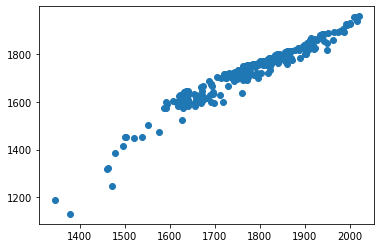

In [908]:
import matplotlib.pyplot as plt
plt.scatter(actual["actual"],actual["predictions"])

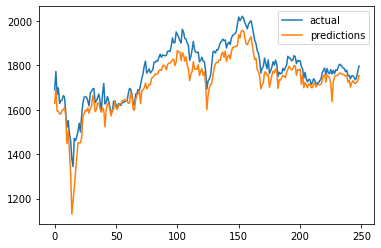

In [909]:
from matplotlib import pyplot as plt
plt.plot(actual["actual"],label="actual")
plt.plot(actual["predictions"],label="predictions")
plt.legend()
plt.show()